### Generative Adversarial Network

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers import LeakyReLU
from keras.optimizers import Adam

How to check if the code is running on GPU or CPU?


```
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
```

How to check if Keras is using GPU?

```
from keras import backend as K

K.tensorflow_backend._get_available_gpus()
```

In [3]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [4]:
(X_train, y_train,X_test, y_test) = load_data()

In [5]:
def adam_optimizer():
    return Adam(lr = 0.0002, beta_1 = 0.5)

In [6]:
def create_generator():
    generator = Sequential()
    generator.add(
        Dense(
            units = 256,
            input_dim = 100
        )
    )
    generator.add(
        LeakyReLU(0.2)
    )
    generator.add(
        Dense(units = 512)
    )
    generator.add(
        LeakyReLU(0.2)
    )
    generator.add(
        Dense(units = 1024)
    )
    generator.add(
        LeakyReLU(0.2)
    )
    generator.add(
        Dense(
            units = 784, 
            activation = 'tanh'
        )
    )
    generator.compile(
        loss = 'binary_crossentropy', 
        optimizer = adam_optimizer()
    )
    return generator

In [7]:
model = create_generator()

/Users/junghunlee/anaconda3/envs/BusinessAnalytics_python/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 784)               8

In [9]:
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(
        Dense(
            units = 1024,
            input_dim = 784
        )
    )
    discriminator.add(
        LeakyReLU(0.2)
    )
    discriminator.add(
        Dropout(0.3)
    )
    discriminator.add(
        Dense(units = 512)
    )
    discriminator.add(
        LeakyReLU(0.2)
    )
    discriminator.add(
        Dropout(0.3)
    )
    discriminator.add(
        Dense(units = 256)
    )
    discriminator.add(
        LeakyReLU(0.2)
    )
    discriminator.add(
        Dense(
            units = 1, 
            activation = 'sigmoid'
        )
    )
    discriminator.compile(
        loss = 'binary_crossentropy', 
        optimizer = adam_optimizer()
    )
    return discriminator

In [10]:
discriminator = create_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)              

In [11]:
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape = (100,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(
        inputs = gan_input, 
        outputs = gan_output)
    gan.compile(
        loss = 'binary_crossentropy', 
        optimizer = 'adam'
    )
    return gan

In [12]:
gan = create_gan(discriminator, model)

gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 784)               1486352   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1460225   
                                                                 
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [34]:
def plot_generated_images(
        epoch, 
        generator, 
        examples : int = 100, 
        dim : tuple = (10, 10), 
        figsize : tuple = (6, 6)
) -> None :
    noise = np.random.normal(loc = 0, scale = 1, size = [examples, 100])
    generated_images = generator.predict(noise, verbose = 0)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize = figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation = 'nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('./gan_image/gan_generated_image %d.png' %epoch)

In [35]:
def training(
        epochs : int = 1, 
        batch_size : int = 128
) -> None:
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator = create_generator()
    discriminator = create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise, verbose = 0)
            
            # Get a random set of  real images
            image_batch = X_train[np.random.randint(low = 0, high = X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:          
            plot_generated_images(e, generator)

100%|██████████| 128/128 [00:06<00:00, 18.78it/s]


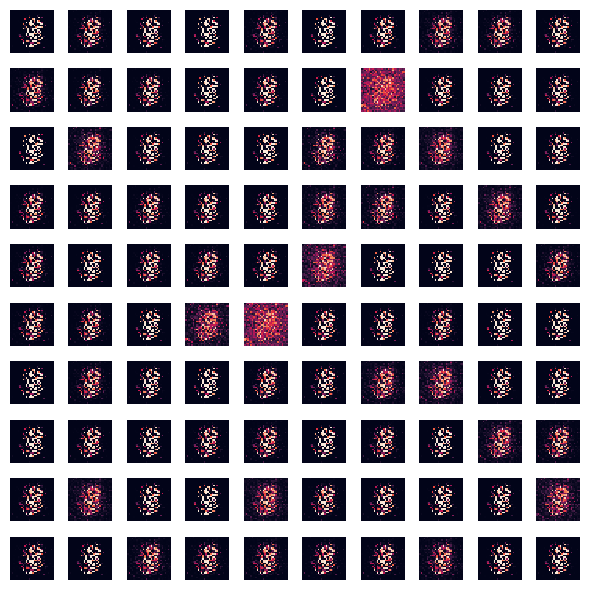

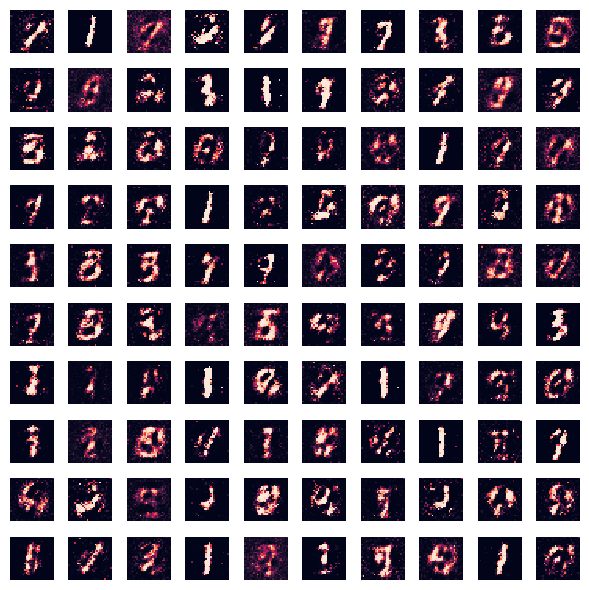

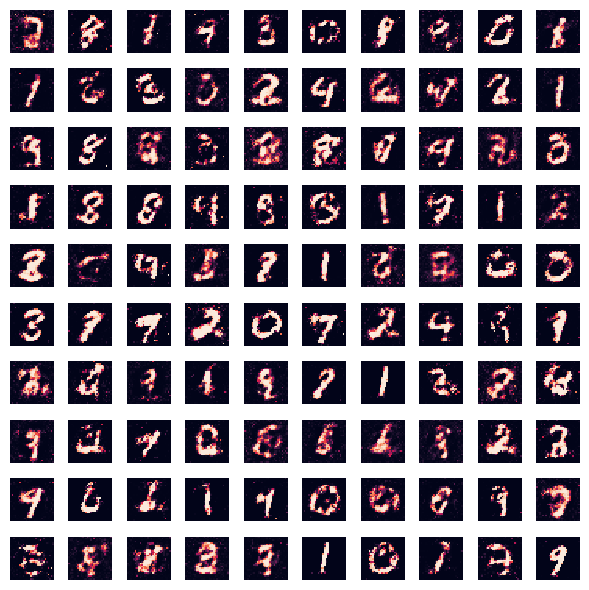

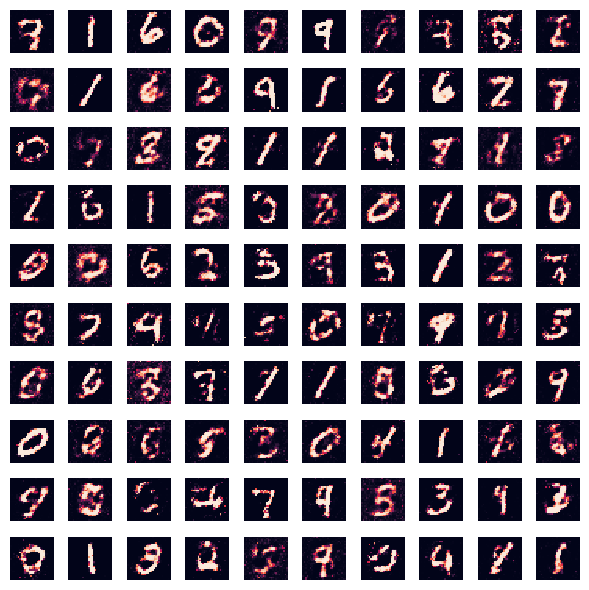

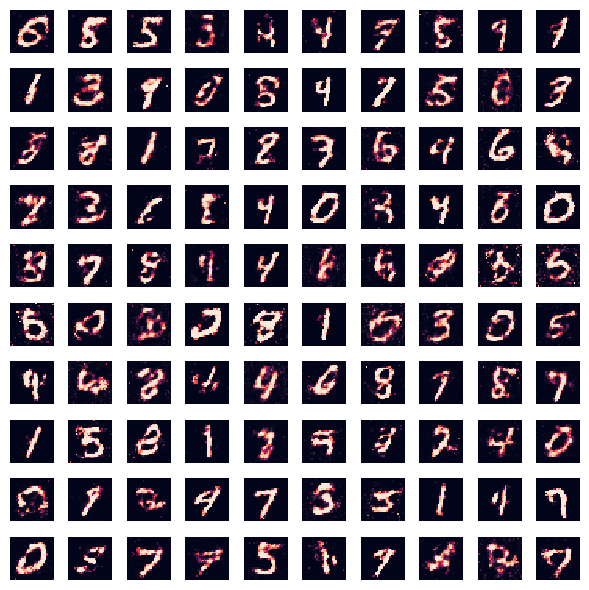

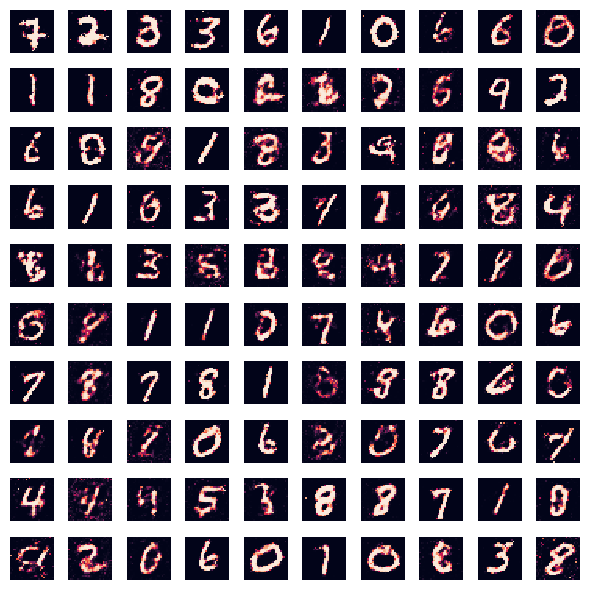

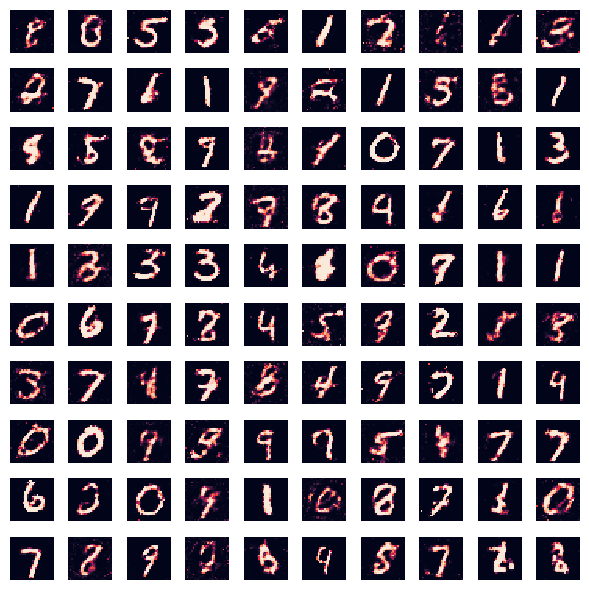

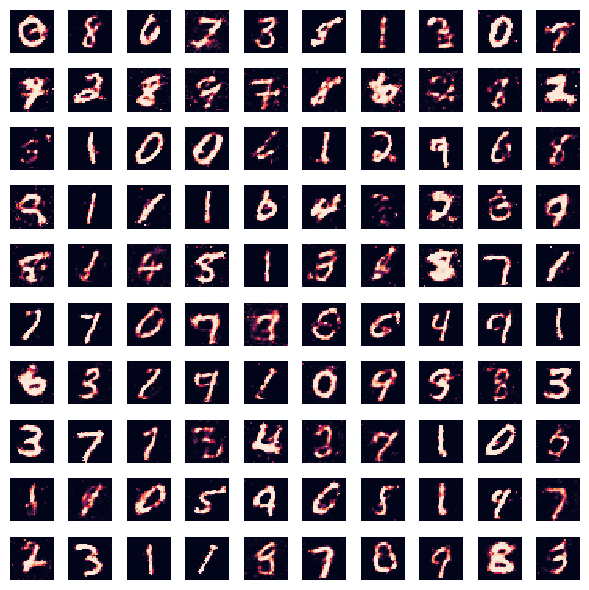

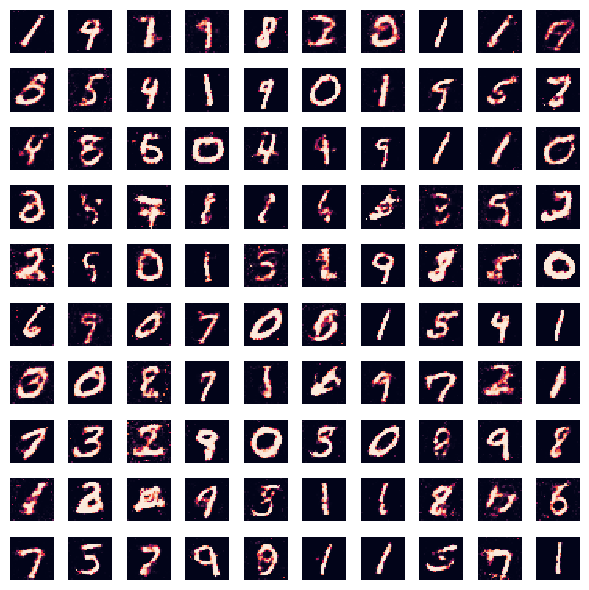

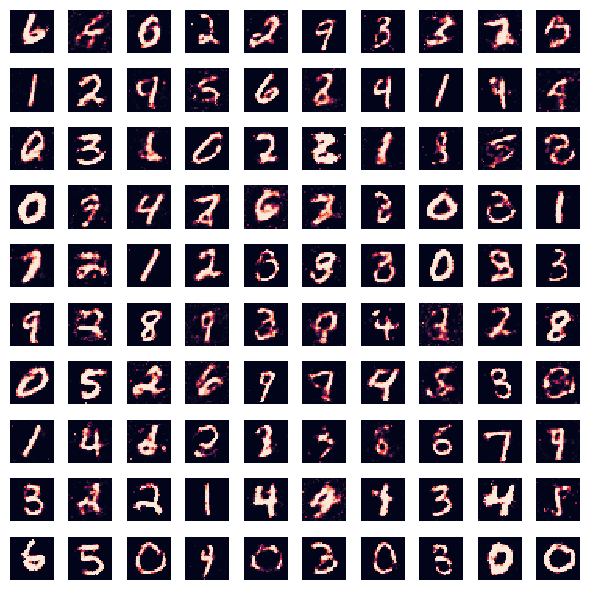

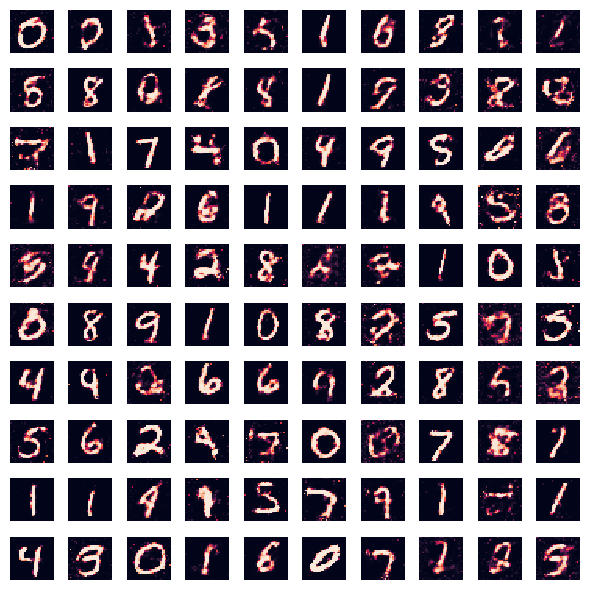

In [36]:
if __name__ == '__main__' : training(200, 128)